### 실습3 ###

영상 기하학 실습을 해봅시다.

**1. Find Homography**

1. 이미지 두 장을 찍어서(평면이면 좋습니다), 이 전에 한 실습처럼 ORB 피처매칭을 하고, 시각화해보세요.

   * note - Homography, Essential Matrix 둘 모두 undistort를 먼저 해야합니다. 일단 현대 핸드폰 카메라의 성능을 믿고 갑시다.

2. https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html 를 참고하여,
   
    Homography를 visualize하지 말고, 1번에서 한 visualize를 해보세요. 

    이 부분에서, matchesMask는 inlier mask를 의미합니다.
    ```python
    matchesMask = mask.ravel().tolist()
    ```

    cv2.drawMatches에 파라미터로 가져다주면 inlier만 그릴겁니다.

3. H를 제대로 정의했다면, 아래 정의시킨 함수'makePanoramaImage'로 파노라마 이미지가 생성됩니다.

In [27]:
#위에 링크에 있는 코드 추가1
import numpy as np   
import cv2 as cv
from matplotlib import pyplot as plt
 
MIN_MATCH_COUNT = 10
 
img1 = cv.imread('//home/jeonghan/대면수업/주행2/datas/kitti/2011_09_26_drive_0035_extract/image_02/data/img1.jpeg', cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('/home/jeonghan/대면수업/주행2/datas/kitti/2011_09_26_drive_0035_extract/image_02/data/img2.jpeg', cv.IMREAD_GRAYSCALE) # trainImage
 
# Initiate SIFT detector
sift = cv.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
 
flann = cv.FlannBasedMatcher(index_params, search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [28]:
#2
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
 
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
 
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
 
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
print(M, mask)

[[ 2.00323451e+00 -1.47057537e-02 -7.45450626e+02]
 [ 3.70174154e-01  1.67164588e+00 -2.59269712e+02]
 [ 9.67419482e-04  2.95639946e-05  1.00000000e+00]] [[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


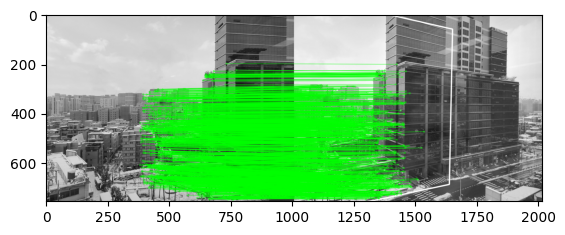

(<matplotlib.image.AxesImage at 0x79fad03cbc70>, None)

In [29]:
#3
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3, 'gray'),plt.show()

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# note H -> src image coordinates to dst_image coordinates
#   cv2.findHomography(src_points, dst_points...
#   를 써서 나온 homography를 H에 제공하면 됩니다.

def makePanoramaImage(src_image, dst_image, H):
    # calculate corners location
    src_h, src_w = src_image.shape[:2]
    dst_h, dst_w = dst_image.shape[:2]
    src_corners = np.float32([[0, 0], [0, src_h], [src_w, src_h], [src_w, 0]]).reshape(-1, 1, 2) # to make 4 1 2 tensor
    
    src_corners_warped = cv2.perspectiveTransform(src_corners, H)
    dst_corners = np.float32([[0, 0], [0, dst_h], [dst_w, dst_h], [dst_w, 0]]).reshape(-1, 1, 2)

    # combine, and calc image size
    all_corners = np.concatenate((src_corners_warped, dst_corners), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # warp src image
    translation_dist = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    output_size = (x_max - x_min, y_max - y_min)

    # warp src to make panorama image
    panorama_image = cv2.warpPerspective(src_image, translation_matrix @ H, output_size)

    # copy dst image to panorama image
    panorama_image[translation_dist[1]:translation_dist[1] + dst_h, translation_dist[0]:translation_dist[0] + dst_w] = dst_image

    return panorama_image




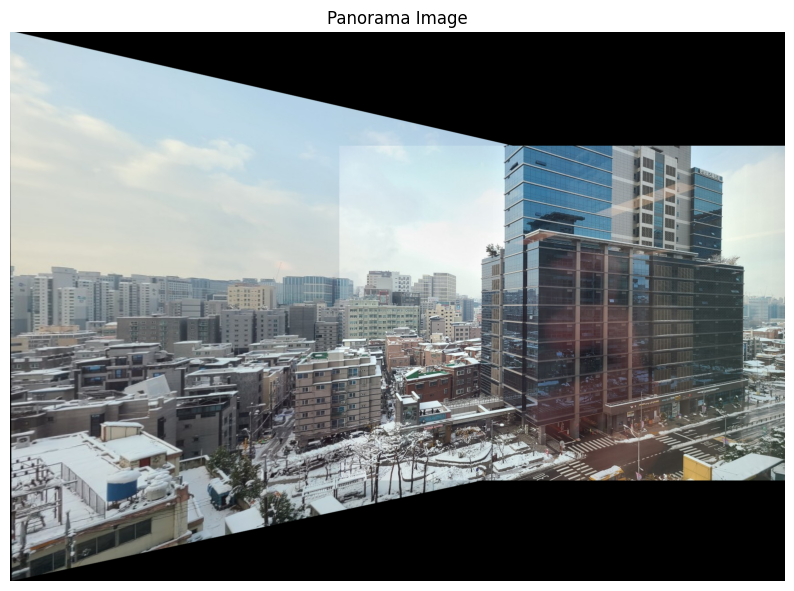

In [31]:
src_image = cv2.imread('/home/jeonghan/대면수업/주행2/datas/kitti/2011_09_26_drive_0035_extract/image_02/data/img1.jpeg')
dst_image = cv2.imread('/home/jeonghan/대면수업/주행2/datas/kitti/2011_09_26_drive_0035_extract/image_02/data/img2.jpeg')
H = np.array([[ 2.00323451e+00, -1.47057537e-02, -7.45450626e+02],
              [ 3.70174154e-01,  1.67164588e+00, -2.59269712e+02],
              [ 9.67419482e-04,  2.95639946e-05,  1.00000000e+00]])

# 파노라마 이미지 생성 (makePanoramaImage 함수에서 나온 결과)
panorama_image = makePanoramaImage(src_image, dst_image, H)

# 이미지를 OpenCV로 읽고, 색상 채널을 BGR에서 RGB로 변환
panorama_image_rgb = cv2.cvtColor(panorama_image, cv2.COLOR_BGR2RGB)

# Matplotlib을 사용하여 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(panorama_image_rgb)
plt.title("Panorama Image")
plt.axis("off")  # 축을 표시하지 않도록 설정
plt.show()